<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [ ]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

In [1]:
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from func.propagation import prop2d, defmodel
# from func.propagation_tf import simulate_obs
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import cupy as cp
device = 'gpu'

In [76]:
# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin)*cdf + vmin
    
    return v.reshape((nz,nx))

# Define cost function
def cost(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	loss_J = J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
	print("Loss (J) = %.4f " % loss_J, end='')
	# Q: Likelihood part
	u = u.flatten()
	penalty = .5 * u.T.dot(Q.toarray()).dot(u)
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = loss_J + penalty * alpha
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,loss_J,penalty*alpha])

	return loss

# Calculate gradient with Adjoint state method
def gradiant(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	receiver_depth = zxrec[0]
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	return G.flatten()*sc.misc.derivative(f,u).flatten() + Q.toarray().dot(u.flatten()) * alpha

# Record loss history over each iterations
def callback(xk):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])

In [37]:
# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,800
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
nrec = len(receivers_width)
zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
print("Number of receivers:", len(zxrec.flatten())//2)
# # Propagajtion
p = prop2d(wsrc,zxsrc,v_ref,at,az,ax,next,device)
print("shape of p(z,x,t) =", p.shape)

dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 800
Number of receivers: 39
shape of p(z,x,t) = (200, 200, 800)


Observation noise std = 1


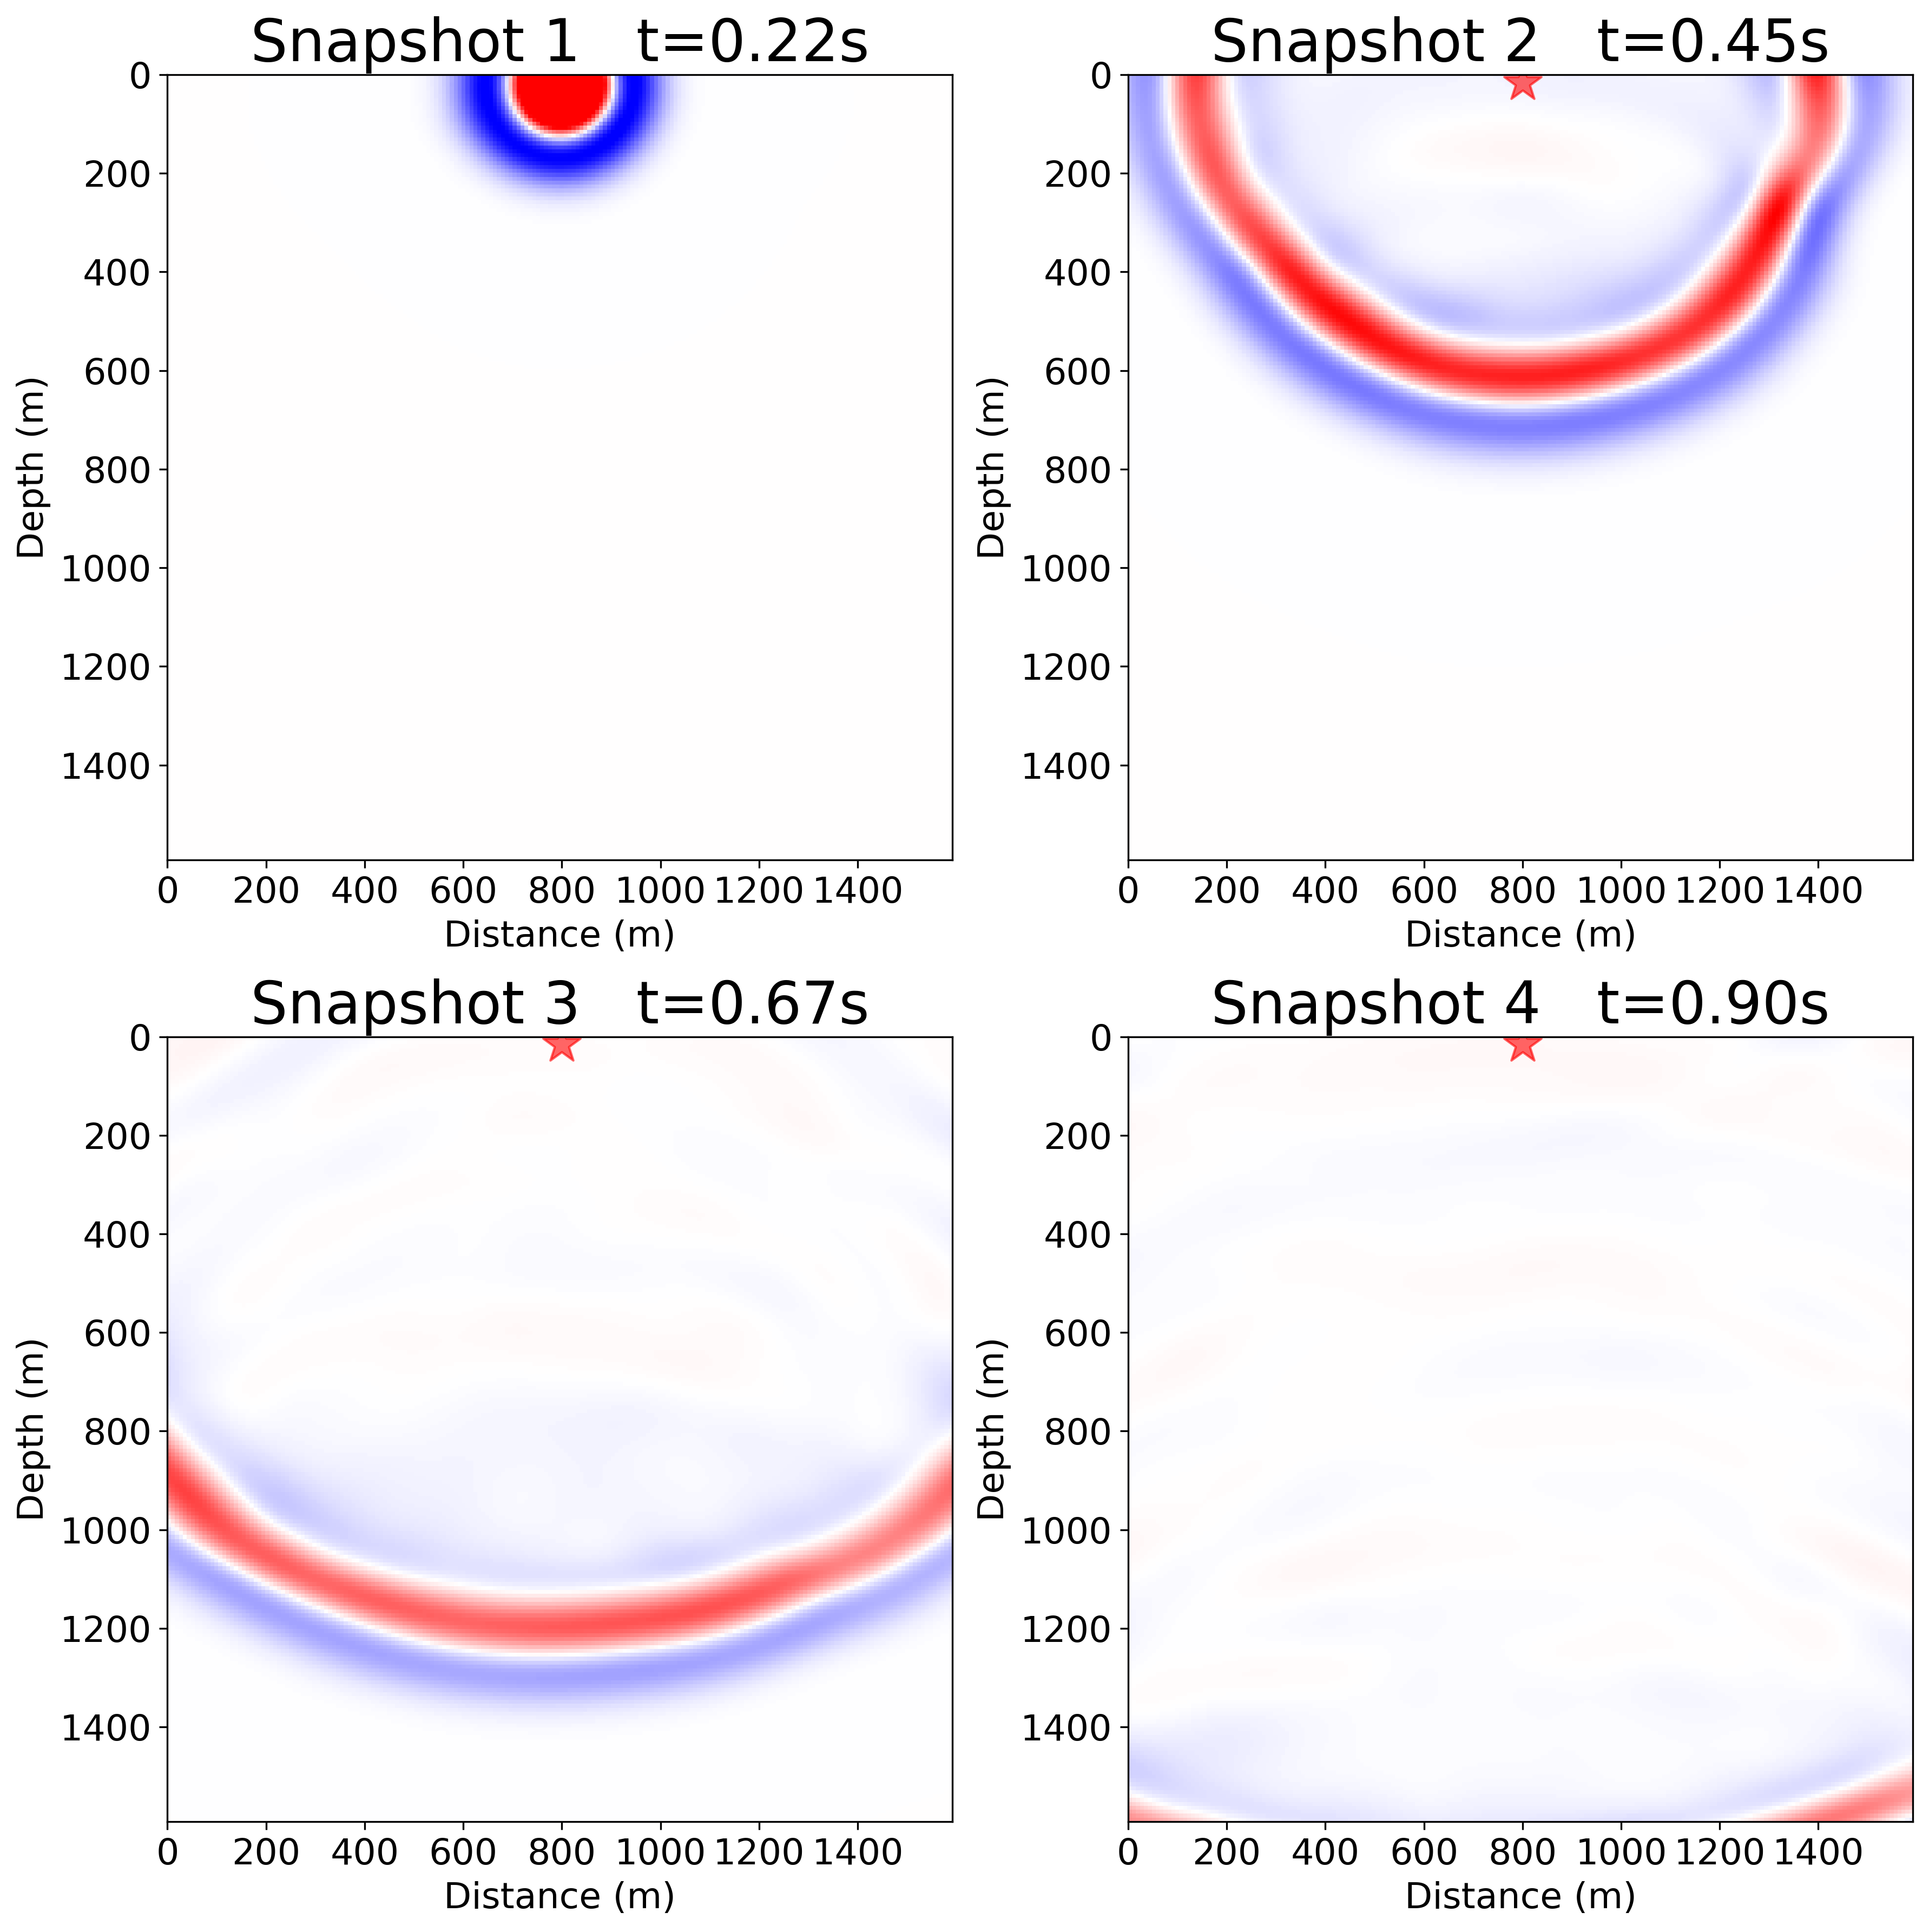

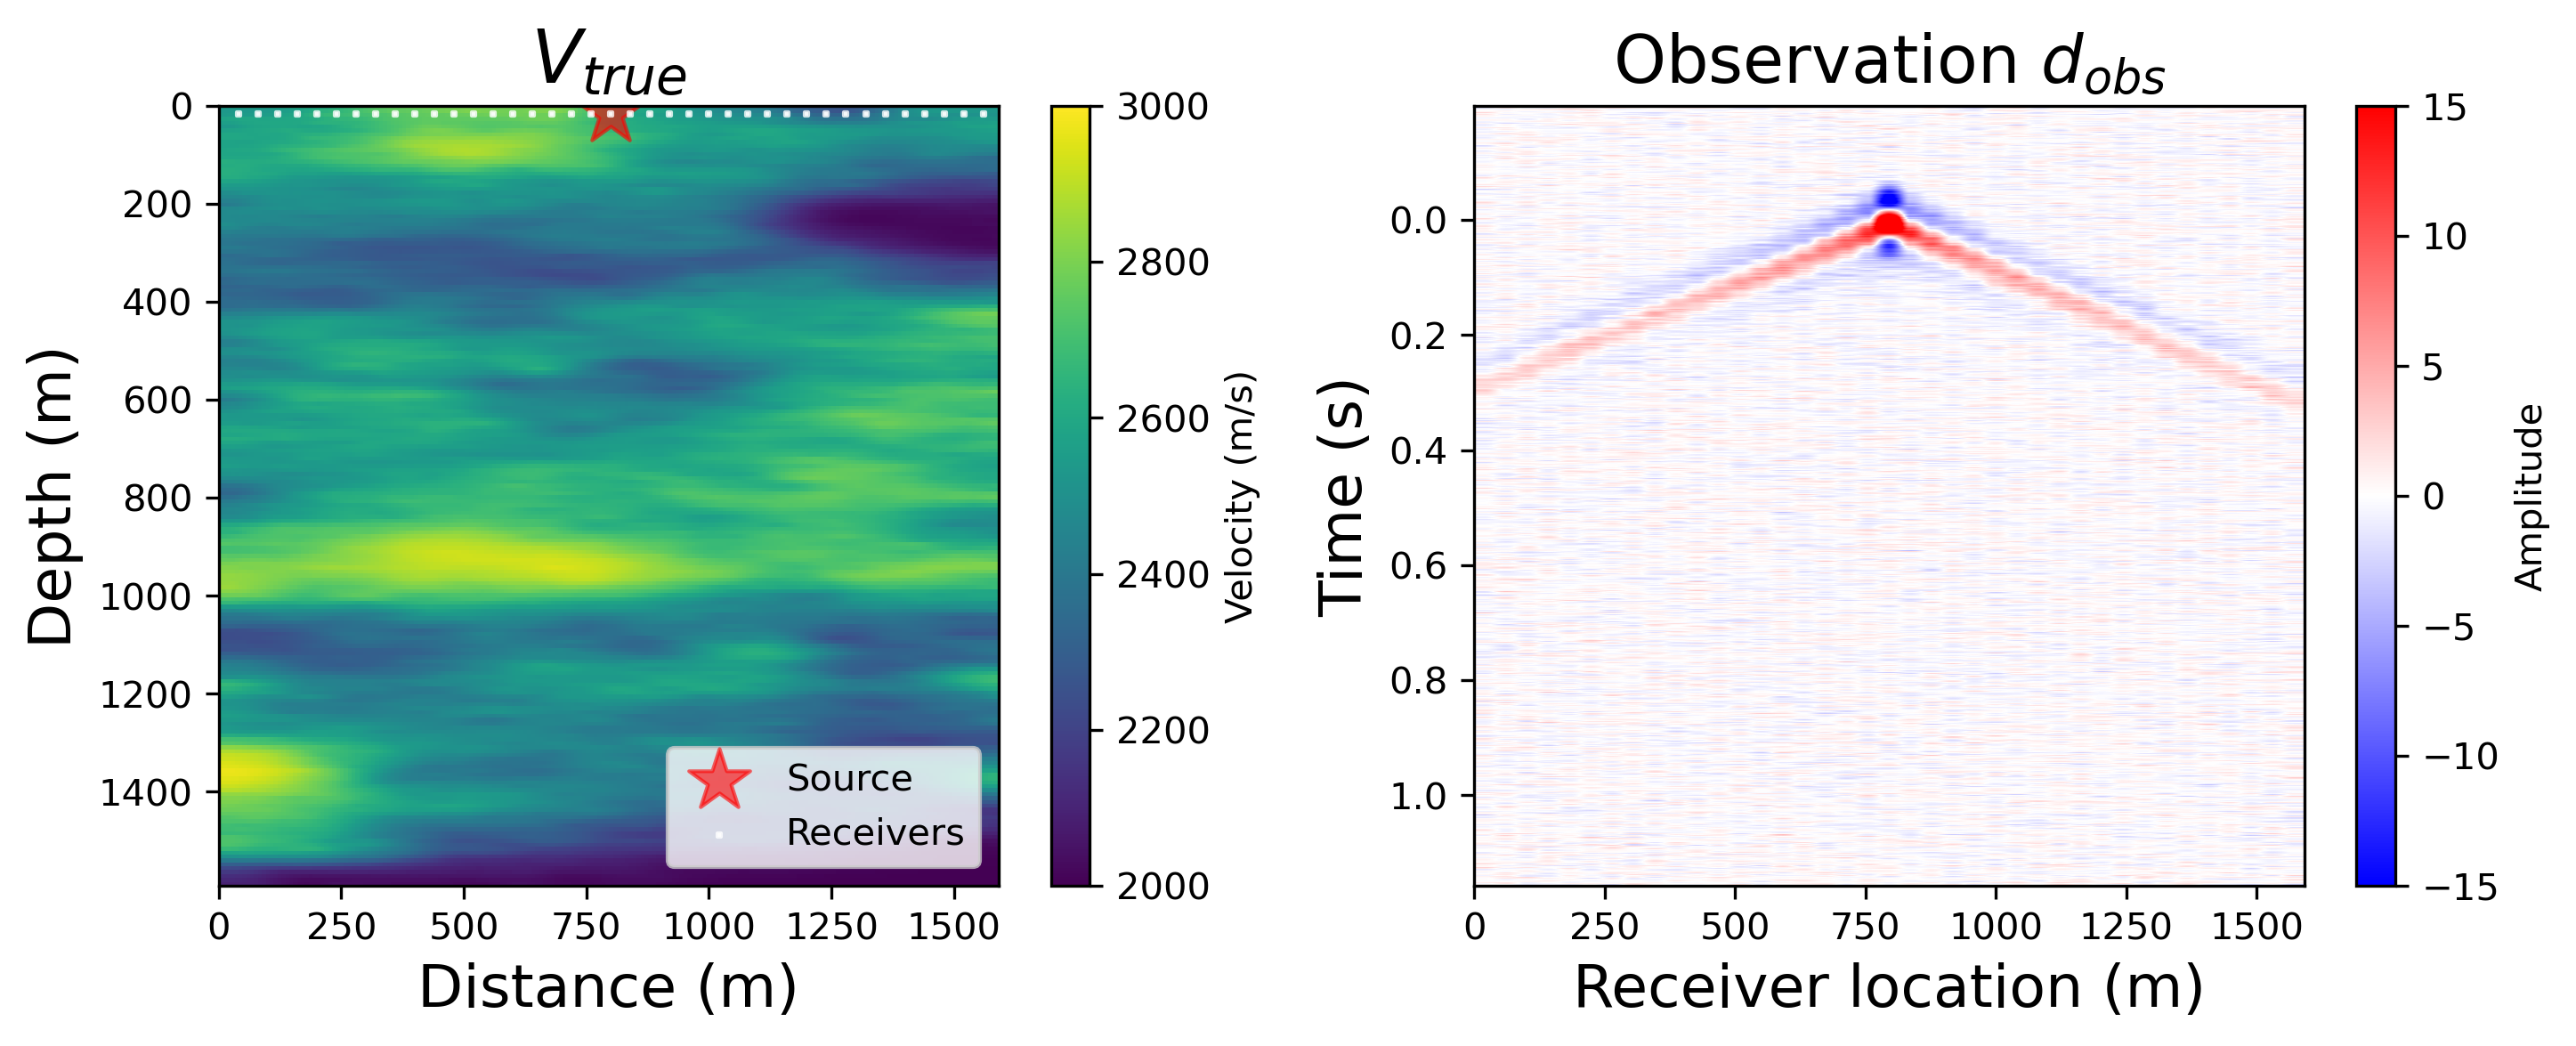

In [146]:
std_noise = 1 # define the noise level
d_obs_no_noise = p[zxrec[0], zxrec[1], :]
d_obs = d_obs_no_noise + np.random.normal(0, std_noise, d_obs_no_noise.shape)
print("Observation noise std =", std_noise)

labelsize = 16
plt.figure(figsize=(12,12), dpi=300,facecolor='white')
pmax = np.max(np.abs(p))/10.
for i in range(1,5):
    plt.subplot(2,2,i)
    t = int(i*(nt)) // 6
    plt.title('Snapshot '+str(i)+'   t='+str(t*dt)[:4]+'s',fontsize=labelsize+10)
    plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
    plt.imshow(p[:,:,t], cmap='bwr', vmin=-pmax, \
                vmax=pmax, extent=[ax[0],ax[-1],az[-1],az[0]], \
                aspect='equal')
    plt.xlabel('Distance (m)', fontsize=labelsize)
    plt.ylabel('Depth (m)', fontsize=labelsize)
    plt.xticks(fontsize=labelsize)
    plt.yticks(fontsize=labelsize)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,4),dpi=300)
plt.subplot(1,2,1) 
plt.imshow(v_ref,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=0.8,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{true}$",fontsize=labelsize+4)
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-15,vmax=15,extent=[az[0], az[-1],at[-1], at[0]], aspect='auto')
cbar = plt.colorbar()
cbar.set_label("Amplitude")
plt.title("Observation $d_{obs}$",fontsize=labelsize+2)
plt.xlabel('Receiver location (m)', fontsize=labelsize)
plt.ylabel('Time (s)', fontsize=labelsize)
plt.tight_layout()
plt.show()

# Display initial gradiant
# plt.figure(figsize=(3,3))
# u_init = np.zeros([nz, nx])   # Set initial velocity guess (u=0 -> v=2500)
# v_init = f(u_init)   # Initial v
# # g_adj = gradiant(v_init,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device='cpu').reshape(nz,nz)
# plt.imshow(g_adj)
# plt.colorbar() 
# plt.title("Adjoint State gradiant")

In [147]:
# minimize cost function
start = time.time()
u_init = np.zeros([nz, nx])   # Set initial velocity guess (u=0 -> v=2500)
v_init = f(u_init)   # Initial v
loss_tracker = np.empty((0,3))
alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = cost, 
               x0 = u_init.flatten(), 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha),
               method='L-BFGS-B', 
               # method='Newton-CG',
            #    bounds = np.full((len(u_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant,
               options = {'disp':True, 'maxiter':150},
               callback=callback
              )
v_fwi = np.reshape(resi.x,(nz,nx))
print(v_fwi.shape)
print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

Loss (J) = 18056.8832 Penalty term = 0.0000 Total loss = 18056.8832 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        40000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80569D+04    |proj g|=  2.71862D+01


 This problem is unconstrained.


Loss (J) = 17797.6914 Penalty term = 1.9354 Total loss = 17799.6267 

At iterate    1    f=  1.77996D+04    |proj g|=  4.62385D+01
Loss (J) = 16257.9493 Penalty term = 8190.6215 Total loss = 24448.5707 
Loss (J) = 17378.2527 Penalty term = 140.7729 Total loss = 17519.0256 

At iterate    2    f=  1.75190D+04    |proj g|=  6.07709D+02
Loss (J) = 16553.5913 Penalty term = 79.0781 Total loss = 16632.6694 

At iterate    3    f=  1.66327D+04    |proj g|=  7.92471D+01
Loss (J) = 16417.2979 Penalty term = 107.8005 Total loss = 16525.0984 

At iterate    4    f=  1.65251D+04    |proj g|=  1.13709D+02
Loss (J) = 16334.5373 Penalty term = 121.8530 Total loss = 16456.3903 

At iterate    5    f=  1.64564D+04    |proj g|=  6.76583D+01
Loss (J) = 16334.9012 Penalty term = 113.0255 Total loss = 16447.9267 

At iterate    6    f=  1.64479D+04    |proj g|=  2.75873D+01
Loss (J) = 16332.8676 Penalty term = 100.1558 Total loss = 16433.0234 

At iterate    7    f=  1.64330D+04    |proj g|=  5.46270D+01


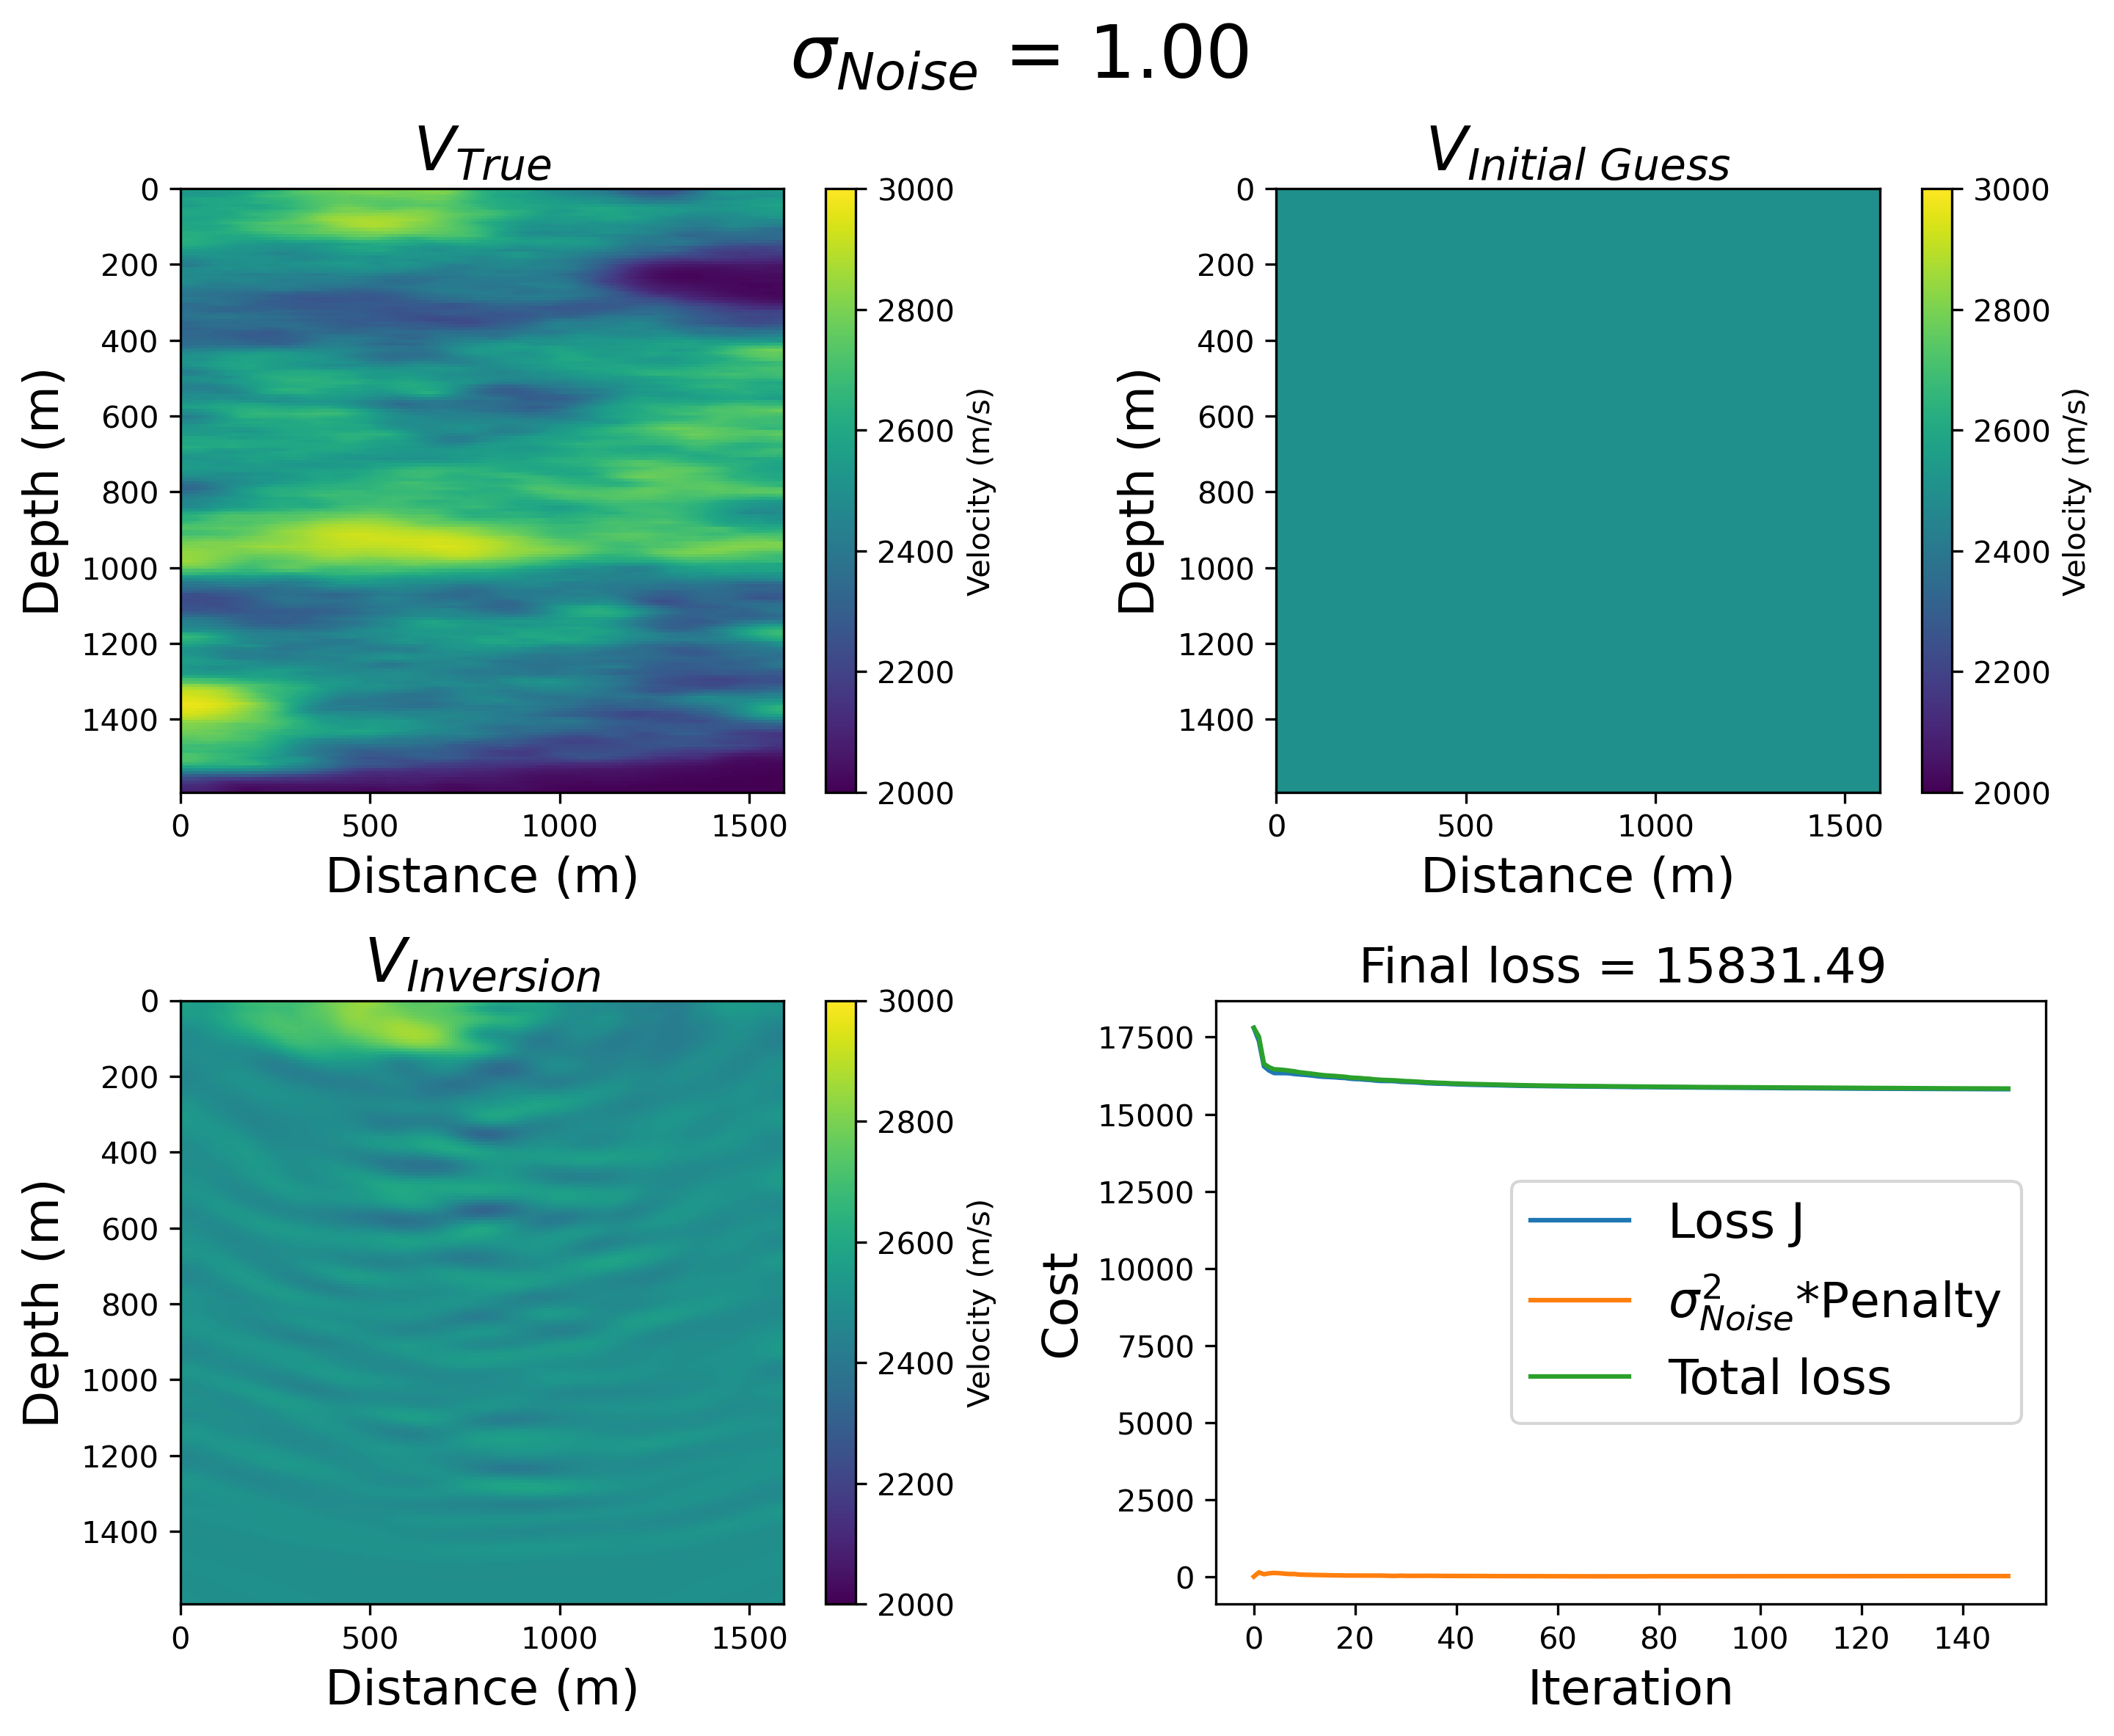

In [148]:
plt.figure(figsize=(10,8),dpi=300)
plt.suptitle("$\sigma_{Noise}$ = %.2f  " % std_noise,fontsize=labelsize+8)
# plt.suptitle("$Loss$ = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.subplot(2,2,1) 
plt.imshow(v_ref,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{True}$",fontsize=labelsize+4)
plt.subplot(2,2,2) 
plt.imshow(v_init,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{Initial\ Guess}$",fontsize=labelsize+4)
plt.subplot(2,2,3)
plt.imshow(f(v_fwi),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=100,alpha=0.6,label="Source")
# plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=0.1,alpha=0.8,label="Receivers")
# plt.legend(loc='lower right')
# plt.title("$V_{Inversion}$ with $\sigma_{Noise}$ = %.2f " % std_noise)
plt.title("$V_{Inversion}$",fontsize=labelsize+4)
plt.subplot(2,2,4)
plt.title("Final loss = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.plot(loss_tracker[:,1],label="Loss J")
plt.plot(loss_tracker[:,2],label="$\sigma_{Noise}^2$*Penalty")
plt.plot(loss_tracker[:,0],label="Total loss")
plt.xlabel("Iteration",fontsize=labelsize)
plt.ylabel("Cost",fontsize=labelsize)
# plt.xlim(0,150)
# plt.ylim(0,1500)
plt.legend(fontsize=labelsize)
plt.tight_layout()
plt.show()

In [145]:
np.max(np.abs(d_obs_no_noise))

37.824245808001976